In [11]:
import pandas as pd
import numpy as np

# -----------------------
# Step 0: Load dataset
# -----------------------
file_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\EDA.xlsx"
final_df = pd.read_excel(file_path, sheet_name="Sheet1")

# Business/judgemental Segmentation (Profile-based)
# Group customers into segments based on their characteristics (demographics, income, product type, etc.) before modeling.
#Example: Salary segment vs. Self-employed vs. Students.
#Purpose: Build separate scorecards for each segment because their risk patterns differ.

# Example: Segmentation based on Income and Age
conditions = [
    (final_df["Income_INR"] < 30000),
    (final_df["Income_INR"].between(30000, 70000)),
    (final_df["Income_INR"] > 70000)
]
labels = ["Low Income", "Middle Income", "High Income"]

final_df["Income_Segment"] = np.select(conditions, labels)

# Check first few rows with Income_INR and Income_Segment
print(final_df[["Income_INR", "Income_Segment"]].head(10))



   Income_INR Income_Segment
0     2309818    High Income
1     2431785    High Income
2      488998    High Income
3     2043400    High Income
4     1279111    High Income
5     1196107    High Income
6      551279    High Income
7     2070230    High Income
8      689570    High Income
9     2250731    High Income


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# step - 1 Target Separation
target = "Default_y"

# Keep predictors only
X = final_df.drop(columns=[target])

# Numeric Feature Selection
X_num = X.select_dtypes(include=[np.number]).fillna(0)

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
#What is StandardScaler()?
#It’s a tool from scikit-learn (a Python machine learning library).
#It is used for feature scaling – adjusting your data so that all features (columns) are on a similar scale.
#Why?
# Because in machine learning, features with very large values (like "salary = 50,000") can 
# dominate smaller ones (like "age = 25"). Scaling prevents this.


# Run KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
final_df["Cluster"] = kmeans.fit_predict(X_scaled)

print("✅ Cluster distribution:")
print(final_df["Cluster"].value_counts())


✅ Cluster distribution:
Cluster
1    43
2    32
0    25
Name: count, dtype: int64


C:\Users\rajat\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
#that means your KMeans segmentation worked and you now have:
#Cluster 1 → 43 customers
#Cluster 2 → 32 customers
#Cluster 0 → 25 customers

In [13]:
# Cluster profile: averages for numeric features + default rate
cluster_profile = final_df.groupby("Cluster").agg(
    count=("Default_y", "size"),
    default_rate=("Default_y", "mean")
)

# Add numeric feature means
num_means = final_df.groupby("Cluster").mean(numeric_only=True)
cluster_profile = cluster_profile.join(num_means)

print("📊 Cluster Profiles:\n")
print(cluster_profile.round(2))

#Why this matters
#This profiling tells you what kind of people are in each cluster.
#You can now decide business actions:
#Cluster 1 (Orange): Prime customers — safest, high income, low spending.
#Cluster 0 (Blue): Affluent but riskier — spend a lot, moderate default.
#Cluster 2 (Green): Vulnerable group — lowest income, highest default.

📊 Cluster Profiles:

         count  default_rate  Behavior_Spending_Score  Income_INR  \
Cluster                                                             
0           25          0.32                    66.52  1491329.32   
1           43          0.26                    39.23  1676008.42   
2           32          0.34                    52.78   937727.31   

         Total_Credit_Limit  Loan_Tenure_Months  \
Cluster                                           
0                1699913.76               39.36   
1                1125618.49               36.56   
2                1733330.31               48.38   

         Months_Since_Most_Recent_Delinquency  Credit_Utilization_Ratio  \
Cluster                                                                   
0                                       31.60                      0.60   
1                                       31.14                      0.42   
2                                       25.34                      0.52   

 

In [14]:
print("Columns in final_df:")
print(final_df.columns.tolist())


Columns in final_df:
['Education_Level', 'Behavior_Spending_Score', 'Income_INR', 'Total_Credit_Limit', 'Loan_Tenure_Months', 'Months_Since_Most_Recent_Delinquency', 'Credit_Utilization_Ratio', 'Credit_Card_Utilization', 'Employment_Years', 'Behavior_Repayment_Score', 'No_of_Inquiries_6M', 'Credit_History_Length', 'Worst_Current_Status', 'No_of_Closed_Accounts', 'Newest_Trade_Open_Months', 'Checking_Account_Balance', 'Pay_History', 'No_of_Inquiries_12M', 'Delinquency_12M', 'Loan_Amount', 'Outstanding_Loans', 'Oldest_Trade_Open_Months', 'Total_Current_Balance', 'Max_Credit_Exposure', 'No_of_Open_Accounts', 'DPD_30', 'Savings_Account_Balance', 'Default_y', 'Income_Segment', 'Cluster']


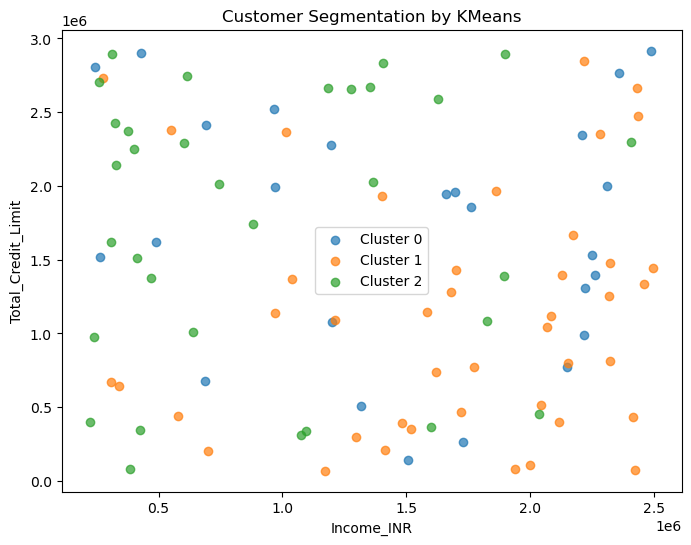

In [15]:
import matplotlib.pyplot as plt

#Set features for the axes
x_feature = "Income_INR"
y_feature = "Total_Credit_Limit"

plt.figure(figsize=(8,6))

for cluster in final_df["Cluster"].unique():   # gives you the list of cluster IDs
    subset = final_df[final_df["Cluster"] == cluster]    # Keeps only rows that belong to that cluster
    plt.scatter(
        subset[x_feature],
        subset[y_feature],
        label=f"Cluster {cluster}",  # legend entry like “Cluster 0”
        alpha=0.7
    )

plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Customer Segmentation by KMeans")
plt.legend()
plt.show()


In [17]:
# -----------------------------
# Create Final Dataset for Next Step
# -----------------------------

# Ensure target is defined
target = "Default_y"

# Keep only predictors + target + cluster
final_features = [col for col in final_df.columns if col not in ["Income_Segment"]]  
# (Dropped Income_Segment if it was engineered earlier to avoid duplication)

final_dataset = final_df[final_features].copy()

print("✅ Final dataset ready")
print("Shape:", final_dataset.shape)
print("Columns:", final_dataset.columns.tolist())

# -----------------------------
# Save to permanent location
# -----------------------------
save_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\EDA_final_dataset.xlsx"
final_dataset.to_excel(save_path, index=False)

print(f"📂 Saved final dataset to: {save_path}")


✅ Final dataset ready
Shape: (100, 29)
Columns: ['Education_Level', 'Behavior_Spending_Score', 'Income_INR', 'Total_Credit_Limit', 'Loan_Tenure_Months', 'Months_Since_Most_Recent_Delinquency', 'Credit_Utilization_Ratio', 'Credit_Card_Utilization', 'Employment_Years', 'Behavior_Repayment_Score', 'No_of_Inquiries_6M', 'Credit_History_Length', 'Worst_Current_Status', 'No_of_Closed_Accounts', 'Newest_Trade_Open_Months', 'Checking_Account_Balance', 'Pay_History', 'No_of_Inquiries_12M', 'Delinquency_12M', 'Loan_Amount', 'Outstanding_Loans', 'Oldest_Trade_Open_Months', 'Total_Current_Balance', 'Max_Credit_Exposure', 'No_of_Open_Accounts', 'DPD_30', 'Savings_Account_Balance', 'Default_y', 'Cluster']
📂 Saved final dataset to: C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\EDA_final_dataset.xlsx
